# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

# Readme


這份作業的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

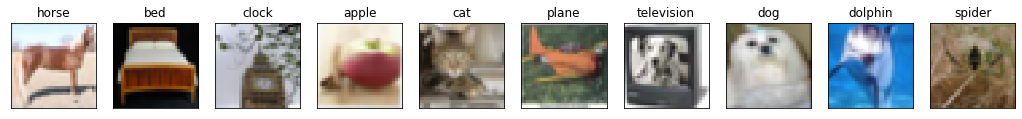

In [1]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

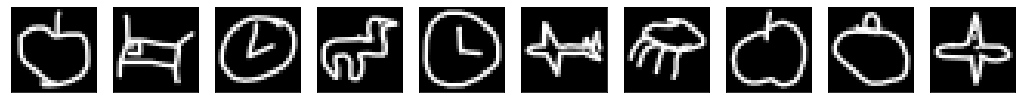

In [2]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

<ipython-input-3-6a76aae1b4d6>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 5, 2)


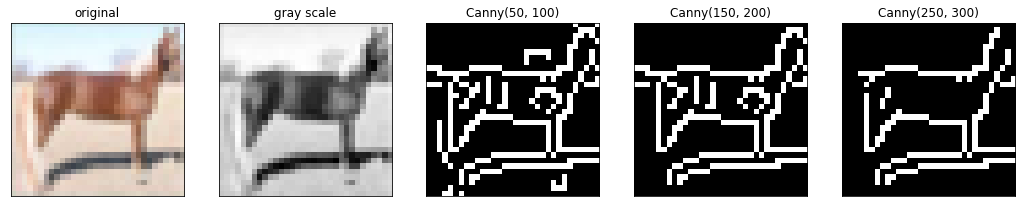

In [3]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。
<!-- 
#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。 -->


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size= 32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size= 32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size = 32, shuffle=False)

# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [5]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [6]:
class ConditionalEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(ConditionalEntropyLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
        b = b.sum(dim=1)
        return -1.0 * b.mean(dim=0)

In [8]:
class VATLoss(nn.Module):
    """
    We define a function of regularization, specifically VAT.
    """

    def __init__(self, model):
        super(VATLoss, self).__init__()
        self.model = model
        self.kl_div = nn.KLDivLoss(size_average=False, reduce=False).to(device)

    def forward(self, X , logit):
        vat_loss = virtual_adversarial_loss(X, logit , self.model, self.kl_div)
        return vat_loss  # already averaged


def kl_divergence_with_logit(q_logit, p_logit):
    q = F.softmax(q_logit, dim=1)
    qlogq = torch.mean(torch.sum(q * F.log_softmax(q_logit, dim=1), dim=1))
    qlogp = torch.mean(torch.sum(q * F.log_softmax(p_logit, dim=1), dim=1))
    return qlogq - qlogp


def get_normalized_vector(d):
    return F.normalize(d.view(d.size(0), -1), p=2, dim=1).reshape(d.size())

def generate_virtual_adversarial_perturbation(x, model):
    d = torch.randn_like(x)
#     for _ in range(n_power):
#         d = get_normalized_vector(d).requires_grad_()
#         #d = XI * get_normalized_vector(d).requires_grad_()
#         logit_m = model(x + d)
#         dist = kl_divergence_with_logit(logit, logit_m)
#         grad = torch.autograd.grad(dist, [d])[0]
#         d = grad.detach()
#     return get_normalized_vector(d)
    return get_normalized_vector(d).requires_grad_()
    #return epsilon * get_normalized_vector(d)


def virtual_adversarial_loss(x,logit, model , kl_div):
    r_vadv = generate_virtual_adversarial_perturbation(x, model)
    prob_logits = F.softmax(logit.detach(), dim=1)
    logit_m = model(x + r_vadv)
    loss = torch.mean(kl_div(
            F.log_softmax(logit_m, dim=1), prob_logits).sum(dim=1))
    return loss

# Pre-processing

這裡我們選用Adam來當Optimizer。

In [9]:
def train_epoch(source_dataloader, target_dataloader,lamb_d,times):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    feature_extractor.train()
    label_predictor.train()
    domain_classifier.train()
    
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        
        lamb_s = 1
        lamb_t = 1e-2
        class_logits = label_predictor(feature)
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss_c = class_criterion(class_logits[:source_data.shape[0]], source_label) 
        loss_d = - lamb_d * domain_criterion(domain_logits, domain_label)
        loss_s = lamb_s * vat_loss(source_data, class_logits[:source_data.shape[0]])
        loss_t = lamb_t * (vat_loss(target_data, class_logits[source_data.shape[0]:]) + cent(class_logits[source_data.shape[0]:]))
        loss = loss_c + loss_d + loss_s + loss_t
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        scheduler_F.step()
        optimizer_C.step()
        scheduler_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits[:source_data.shape[0]], dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')
    time = times + 3
    name_feature = 'extractor_model_vada_v'+str(time)+'.bin'
    name_predictor = 'predictor_model_vada_v'+str(time)+'.bin'
    torch.save(feature_extractor.state_dict(), name_feature)
    torch.save(label_predictor.state_dict(), name_predictor)
    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

def inference(epoch ,times):
    result = []
    label_predictor.eval()
    feature_extractor.eval()
    for i, (test_data, _) in enumerate(test_dataloader):
        test_data = test_data.cuda()

        class_logits = label_predictor(feature_extractor(test_data))

        x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
        result.append(x)

    import pandas as pd
    result = np.concatenate(result)
    time = times + 3
    # Generate your submission
    tmp = './vada/result_v' + str(time) +'_'+ str(epoch) +'.csv'
    df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
    df.to_csv(tmp,index=False)
    label_predictor.train()
    feature_extractor.train()
    
 

In [10]:
times = 1
for i in range(times):
    learning_rate = 1e-3
    feature_extractor = FeatureExtractor().cuda()
    label_predictor = LabelPredictor().cuda()
    domain_classifier = DomainClassifier().cuda()
    model = nn.Sequential(feature_extractor , label_predictor)
    optimizer_F = optim.Adam(feature_extractor.parameters() , lr = learning_rate)
    optimizer_C = optim.Adam(label_predictor.parameters() , lr = learning_rate)
    optimizer_D = optim.Adam(domain_classifier.parameters() , lr = learning_rate)    
    scheduler_F = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_F , T_max = 500)
    scheduler_C = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_C , T_max = 500)
    class_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    cent = ConditionalEntropyLoss()
    vat_loss = VATLoss(model)

    total_epoch = 3000
    # train 200 epochs
    for epoch in range(total_epoch):
        # You should chooose lamnda cleverly.
        lamb_d = 2/(1 + np.exp(-10 * epoch / total_epoch)) - 1
        train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader ,lamb_d,i)
        if (epoch % 500 == 0 and epoch != 0) or epoch == 3999:
            inference(epoch , i)
        print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

C:\Users\mark0\Anaconda3\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


epoch   0: train D loss: 0.4289, train F loss: 1.9782, acc 0.2918
epoch   1: train D loss: 0.3048, train F loss: 1.6380, acc 0.4280
epoch   2: train D loss: 0.1949, train F loss: 1.4440, acc 0.5024
epoch   3: train D loss: 0.1711, train F loss: 1.3761, acc 0.5198
epoch   4: train D loss: 0.1883, train F loss: 1.4326, acc 0.5050
epoch   5: train D loss: 0.3097, train F loss: 1.4741, acc 0.4972
epoch   6: train D loss: 0.3636, train F loss: 1.4290, acc 0.5114
epoch   7: train D loss: 0.2829, train F loss: 1.3139, acc 0.5522
epoch   8: train D loss: 0.2318, train F loss: 1.1794, acc 0.5998
epoch   9: train D loss: 0.2026, train F loss: 1.0919, acc 0.6226
epoch  10: train D loss: 0.1902, train F loss: 1.1109, acc 0.6266
epoch  11: train D loss: 0.2345, train F loss: 1.2305, acc 0.5864
epoch  12: train D loss: 0.3188, train F loss: 1.2582, acc 0.5754
epoch  13: train D loss: 0.2973, train F loss: 1.2137, acc 0.5876
epoch  14: train D loss: 0.2415, train F loss: 1.0567, acc 0.6378
epoch  15:

epoch 125: train D loss: 0.2837, train F loss: 0.0477, acc 0.9792
epoch 126: train D loss: 0.4271, train F loss: 0.0958, acc 0.9578
epoch 127: train D loss: 0.4511, train F loss: 0.1250, acc 0.9440
epoch 128: train D loss: 0.4055, train F loss: 0.1217, acc 0.9494
epoch 129: train D loss: 0.3563, train F loss: 0.0536, acc 0.9744
epoch 130: train D loss: 0.2829, train F loss: 0.0358, acc 0.9810
epoch 131: train D loss: 0.2568, train F loss: 0.0415, acc 0.9802
epoch 132: train D loss: 0.3938, train F loss: 0.0479, acc 0.9738
epoch 133: train D loss: 0.4468, train F loss: 0.1479, acc 0.9398
epoch 134: train D loss: 0.4386, train F loss: 0.1156, acc 0.9498
epoch 135: train D loss: 0.3934, train F loss: 0.0428, acc 0.9730
epoch 136: train D loss: 0.3120, train F loss: 0.0246, acc 0.9830
epoch 137: train D loss: 0.2649, train F loss: 0.0259, acc 0.9854
epoch 138: train D loss: 0.3498, train F loss: 0.0453, acc 0.9766
epoch 139: train D loss: 0.4579, train F loss: 0.0929, acc 0.9536
epoch 140:

epoch 249: train D loss: 0.5717, train F loss: -0.0817, acc 0.9808
epoch 250: train D loss: 0.4932, train F loss: -0.0778, acc 0.9852
epoch 251: train D loss: 0.3939, train F loss: -0.0623, acc 0.9876
epoch 252: train D loss: 0.3710, train F loss: -0.0548, acc 0.9894
epoch 253: train D loss: 0.5431, train F loss: -0.1011, acc 0.9866
epoch 254: train D loss: 0.5717, train F loss: -0.0489, acc 0.9684
epoch 255: train D loss: 0.5843, train F loss: -0.0697, acc 0.9748
epoch 256: train D loss: 0.5208, train F loss: -0.0863, acc 0.9838
epoch 257: train D loss: 0.4231, train F loss: -0.0760, acc 0.9904
epoch 258: train D loss: 0.3490, train F loss: -0.0540, acc 0.9892
epoch 259: train D loss: 0.4797, train F loss: -0.0798, acc 0.9860
epoch 260: train D loss: 0.5805, train F loss: -0.0726, acc 0.9744
epoch 261: train D loss: 0.6008, train F loss: -0.0855, acc 0.9732
epoch 262: train D loss: 0.5685, train F loss: -0.0928, acc 0.9776
epoch 263: train D loss: 0.4586, train F loss: -0.0802, acc 0.

epoch 372: train D loss: 0.4460, train F loss: -0.1270, acc 0.9878
epoch 373: train D loss: 0.4034, train F loss: -0.1156, acc 0.9906
epoch 374: train D loss: 0.5978, train F loss: -0.1909, acc 0.9866
epoch 375: train D loss: 0.6359, train F loss: -0.1941, acc 0.9802
epoch 376: train D loss: 0.6319, train F loss: -0.1874, acc 0.9792
epoch 377: train D loss: 0.5983, train F loss: -0.2000, acc 0.9852
epoch 378: train D loss: 0.4945, train F loss: -0.1653, acc 0.9892
epoch 379: train D loss: 0.3877, train F loss: -0.1196, acc 0.9926
epoch 380: train D loss: 0.5470, train F loss: -0.1881, acc 0.9910
epoch 381: train D loss: 0.6304, train F loss: -0.2041, acc 0.9834
epoch 382: train D loss: 0.6396, train F loss: -0.1904, acc 0.9776
epoch 383: train D loss: 0.6065, train F loss: -0.1871, acc 0.9824
epoch 384: train D loss: 0.5420, train F loss: -0.1822, acc 0.9886
epoch 385: train D loss: 0.4242, train F loss: -0.1326, acc 0.9908
epoch 386: train D loss: 0.4547, train F loss: -0.1454, acc 0.

epoch 495: train D loss: 0.6281, train F loss: -0.2855, acc 0.9886
epoch 496: train D loss: 0.6486, train F loss: -0.2829, acc 0.9840
epoch 497: train D loss: 0.6570, train F loss: -0.2865, acc 0.9846
epoch 498: train D loss: 0.6194, train F loss: -0.2795, acc 0.9864
epoch 499: train D loss: 0.5369, train F loss: -0.2391, acc 0.9906
epoch 500: train D loss: 0.4350, train F loss: -0.1785, acc 0.9910
epoch 501: train D loss: 0.5650, train F loss: -0.2517, acc 0.9916
epoch 502: train D loss: 0.6510, train F loss: -0.2909, acc 0.9836
epoch 503: train D loss: 0.6556, train F loss: -0.2848, acc 0.9798
epoch 504: train D loss: 0.6448, train F loss: -0.2960, acc 0.9864
epoch 505: train D loss: 0.5732, train F loss: -0.2641, acc 0.9902
epoch 506: train D loss: 0.4309, train F loss: -0.1883, acc 0.9926
epoch 507: train D loss: 0.4846, train F loss: -0.2104, acc 0.9908
epoch 508: train D loss: 0.6540, train F loss: -0.3117, acc 0.9902
epoch 509: train D loss: 0.6630, train F loss: -0.2944, acc 0.

epoch 618: train D loss: 0.6666, train F loss: -0.3674, acc 0.9842
epoch 619: train D loss: 0.6247, train F loss: -0.3444, acc 0.9862
epoch 620: train D loss: 0.5302, train F loss: -0.2879, acc 0.9908
epoch 621: train D loss: 0.4306, train F loss: -0.2244, acc 0.9928
epoch 622: train D loss: 0.5862, train F loss: -0.3203, acc 0.9902
epoch 623: train D loss: 0.6701, train F loss: -0.3808, acc 0.9874
epoch 624: train D loss: 0.6686, train F loss: -0.3585, acc 0.9814
epoch 625: train D loss: 0.6526, train F loss: -0.3658, acc 0.9842
epoch 626: train D loss: 0.5917, train F loss: -0.3252, acc 0.9868
epoch 627: train D loss: 0.4802, train F loss: -0.2572, acc 0.9912
epoch 628: train D loss: 0.5029, train F loss: -0.2749, acc 0.9918
epoch 629: train D loss: 0.6735, train F loss: -0.3833, acc 0.9884
epoch 630: train D loss: 0.6686, train F loss: -0.3671, acc 0.9846
epoch 631: train D loss: 0.6621, train F loss: -0.3821, acc 0.9890
epoch 632: train D loss: 0.6288, train F loss: -0.3694, acc 0.

epoch 741: train D loss: 0.5774, train F loss: -0.3720, acc 0.9912
epoch 742: train D loss: 0.4605, train F loss: -0.2828, acc 0.9924
epoch 743: train D loss: 0.6001, train F loss: -0.3784, acc 0.9904
epoch 744: train D loss: 0.6813, train F loss: -0.4512, acc 0.9914
epoch 745: train D loss: 0.6738, train F loss: -0.4295, acc 0.9862
epoch 746: train D loss: 0.6696, train F loss: -0.4388, acc 0.9880
epoch 747: train D loss: 0.6356, train F loss: -0.4214, acc 0.9910
epoch 748: train D loss: 0.5352, train F loss: -0.3428, acc 0.9916
epoch 749: train D loss: 0.5595, train F loss: -0.3569, acc 0.9932
epoch 750: train D loss: 0.6615, train F loss: -0.4316, acc 0.9894
epoch 751: train D loss: 0.6749, train F loss: -0.4246, acc 0.9856
epoch 752: train D loss: 0.6613, train F loss: -0.4290, acc 0.9884
epoch 753: train D loss: 0.6530, train F loss: -0.4292, acc 0.9876
epoch 754: train D loss: 0.5586, train F loss: -0.3634, acc 0.9924
epoch 755: train D loss: 0.4921, train F loss: -0.3044, acc 0.

epoch 864: train D loss: 0.6078, train F loss: -0.4272, acc 0.9920
epoch 865: train D loss: 0.6805, train F loss: -0.4845, acc 0.9882
epoch 866: train D loss: 0.6802, train F loss: -0.4774, acc 0.9866
epoch 867: train D loss: 0.6685, train F loss: -0.4695, acc 0.9868
epoch 868: train D loss: 0.6230, train F loss: -0.4526, acc 0.9924
epoch 869: train D loss: 0.5187, train F loss: -0.3608, acc 0.9932
epoch 870: train D loss: 0.5480, train F loss: -0.3801, acc 0.9932
epoch 871: train D loss: 0.6806, train F loss: -0.4959, acc 0.9912
epoch 872: train D loss: 0.6848, train F loss: -0.4838, acc 0.9868
epoch 873: train D loss: 0.6772, train F loss: -0.4905, acc 0.9896
epoch 874: train D loss: 0.6386, train F loss: -0.4646, acc 0.9924
epoch 875: train D loss: 0.5503, train F loss: -0.3901, acc 0.9922
epoch 876: train D loss: 0.4832, train F loss: -0.3335, acc 0.9926
epoch 877: train D loss: 0.6554, train F loss: -0.4792, acc 0.9936
epoch 878: train D loss: 0.6745, train F loss: -0.4917, acc 0.

epoch 987: train D loss: 0.6736, train F loss: -0.5167, acc 0.9882
epoch 988: train D loss: 0.6716, train F loss: -0.5239, acc 0.9910
epoch 989: train D loss: 0.6376, train F loss: -0.4932, acc 0.9910
epoch 990: train D loss: 0.5251, train F loss: -0.3917, acc 0.9924
epoch 991: train D loss: 0.5487, train F loss: -0.4106, acc 0.9930
epoch 992: train D loss: 0.6762, train F loss: -0.5233, acc 0.9916
epoch 993: train D loss: 0.6853, train F loss: -0.5272, acc 0.9894
epoch 994: train D loss: 0.6721, train F loss: -0.5104, acc 0.9878
epoch 995: train D loss: 0.6601, train F loss: -0.5178, acc 0.9918
epoch 996: train D loss: 0.5919, train F loss: -0.4593, acc 0.9942
epoch 997: train D loss: 0.5242, train F loss: -0.3909, acc 0.9928
epoch 998: train D loss: 0.6529, train F loss: -0.5071, acc 0.9922
epoch 999: train D loss: 0.6933, train F loss: -0.5311, acc 0.9874
epoch 1000: train D loss: 0.6774, train F loss: -0.5215, acc 0.9868
epoch 1001: train D loss: 0.6694, train F loss: -0.5257, acc 

epoch 1108: train D loss: 0.6829, train F loss: -0.5612, acc 0.9906
epoch 1109: train D loss: 0.6710, train F loss: -0.5453, acc 0.9890
epoch 1110: train D loss: 0.6500, train F loss: -0.5320, acc 0.9910
epoch 1111: train D loss: 0.5717, train F loss: -0.4639, acc 0.9936
epoch 1112: train D loss: 0.5773, train F loss: -0.4600, acc 0.9940
epoch 1113: train D loss: 0.6839, train F loss: -0.5625, acc 0.9934
epoch 1114: train D loss: 0.6816, train F loss: -0.5579, acc 0.9910
epoch 1115: train D loss: 0.6781, train F loss: -0.5417, acc 0.9868
epoch 1116: train D loss: 0.6580, train F loss: -0.5443, acc 0.9928
epoch 1117: train D loss: 0.5794, train F loss: -0.4662, acc 0.9924
epoch 1118: train D loss: 0.5094, train F loss: -0.3953, acc 0.9928
epoch 1119: train D loss: 0.6575, train F loss: -0.5337, acc 0.9936
epoch 1120: train D loss: 0.6884, train F loss: -0.5558, acc 0.9906
epoch 1121: train D loss: 0.6841, train F loss: -0.5506, acc 0.9880
epoch 1122: train D loss: 0.6672, train F loss: 

epoch 1229: train D loss: 0.6870, train F loss: -0.5830, acc 0.9908
epoch 1230: train D loss: 0.6735, train F loss: -0.5762, acc 0.9912
epoch 1231: train D loss: 0.6380, train F loss: -0.5444, acc 0.9924
epoch 1232: train D loss: 0.5480, train F loss: -0.4534, acc 0.9914
epoch 1233: train D loss: 0.5562, train F loss: -0.4560, acc 0.9924
epoch 1234: train D loss: 0.6885, train F loss: -0.5888, acc 0.9936
epoch 1235: train D loss: 0.6837, train F loss: -0.5756, acc 0.9918
epoch 1236: train D loss: 0.6763, train F loss: -0.5617, acc 0.9862
epoch 1237: train D loss: 0.6597, train F loss: -0.5560, acc 0.9904
epoch 1238: train D loss: 0.5975, train F loss: -0.5075, acc 0.9944
epoch 1239: train D loss: 0.5302, train F loss: -0.4317, acc 0.9934
epoch 1240: train D loss: 0.6619, train F loss: -0.5568, acc 0.9924
epoch 1241: train D loss: 0.6827, train F loss: -0.5722, acc 0.9892
epoch 1242: train D loss: 0.6825, train F loss: -0.5822, acc 0.9910
epoch 1243: train D loss: 0.6679, train F loss: 

epoch 1350: train D loss: 0.6880, train F loss: -0.5966, acc 0.9904
epoch 1351: train D loss: 0.6758, train F loss: -0.5895, acc 0.9902
epoch 1352: train D loss: 0.6464, train F loss: -0.5641, acc 0.9916
epoch 1353: train D loss: 0.5660, train F loss: -0.4866, acc 0.9938
epoch 1354: train D loss: 0.5631, train F loss: -0.4741, acc 0.9940
epoch 1355: train D loss: 0.6886, train F loss: -0.6020, acc 0.9930
epoch 1356: train D loss: 0.6870, train F loss: -0.5870, acc 0.9890
epoch 1357: train D loss: 0.6776, train F loss: -0.5945, acc 0.9912
epoch 1358: train D loss: 0.6636, train F loss: -0.5807, acc 0.9930
epoch 1359: train D loss: 0.6023, train F loss: -0.5225, acc 0.9920
epoch 1360: train D loss: 0.5268, train F loss: -0.4460, acc 0.9936
epoch 1361: train D loss: 0.6523, train F loss: -0.5632, acc 0.9924
epoch 1362: train D loss: 0.6987, train F loss: -0.6097, acc 0.9920
epoch 1363: train D loss: 0.6832, train F loss: -0.5808, acc 0.9858
epoch 1364: train D loss: 0.6719, train F loss: 

epoch 1471: train D loss: 0.6828, train F loss: -0.6016, acc 0.9892
epoch 1472: train D loss: 0.6750, train F loss: -0.6019, acc 0.9930
epoch 1473: train D loss: 0.6566, train F loss: -0.5943, acc 0.9954
epoch 1474: train D loss: 0.5997, train F loss: -0.5361, acc 0.9952
epoch 1475: train D loss: 0.5824, train F loss: -0.5114, acc 0.9940
epoch 1476: train D loss: 0.6856, train F loss: -0.6130, acc 0.9940
epoch 1477: train D loss: 0.6902, train F loss: -0.6077, acc 0.9894
epoch 1478: train D loss: 0.6855, train F loss: -0.6022, acc 0.9888
epoch 1479: train D loss: 0.6649, train F loss: -0.5995, acc 0.9922
epoch 1480: train D loss: 0.6150, train F loss: -0.5498, acc 0.9946
epoch 1481: train D loss: 0.5374, train F loss: -0.4674, acc 0.9944
epoch 1482: train D loss: 0.6627, train F loss: -0.5876, acc 0.9932
epoch 1483: train D loss: 0.6931, train F loss: -0.6124, acc 0.9892
epoch 1484: train D loss: 0.6876, train F loss: -0.5965, acc 0.9862
epoch 1485: train D loss: 0.6787, train F loss: 

epoch 1592: train D loss: 0.6824, train F loss: -0.6060, acc 0.9884
epoch 1593: train D loss: 0.6775, train F loss: -0.6111, acc 0.9902
epoch 1594: train D loss: 0.6544, train F loss: -0.5955, acc 0.9938
epoch 1595: train D loss: 0.5952, train F loss: -0.5303, acc 0.9934
epoch 1596: train D loss: 0.5855, train F loss: -0.5165, acc 0.9938
epoch 1597: train D loss: 0.6884, train F loss: -0.6222, acc 0.9934
epoch 1598: train D loss: 0.6865, train F loss: -0.6126, acc 0.9916
epoch 1599: train D loss: 0.6776, train F loss: -0.6121, acc 0.9908
epoch 1600: train D loss: 0.6603, train F loss: -0.6022, acc 0.9934
epoch 1601: train D loss: 0.6164, train F loss: -0.5636, acc 0.9952
epoch 1602: train D loss: 0.5645, train F loss: -0.5009, acc 0.9942
epoch 1603: train D loss: 0.6683, train F loss: -0.5960, acc 0.9914
epoch 1604: train D loss: 0.6922, train F loss: -0.6242, acc 0.9908
epoch 1605: train D loss: 0.6819, train F loss: -0.6013, acc 0.9892
epoch 1606: train D loss: 0.6719, train F loss: 

epoch 1713: train D loss: 0.6837, train F loss: -0.6215, acc 0.9932
epoch 1714: train D loss: 0.6729, train F loss: -0.6101, acc 0.9916
epoch 1715: train D loss: 0.6518, train F loss: -0.6019, acc 0.9942
epoch 1716: train D loss: 0.6038, train F loss: -0.5516, acc 0.9936
epoch 1717: train D loss: 0.5934, train F loss: -0.5353, acc 0.9952
epoch 1718: train D loss: 0.6896, train F loss: -0.6290, acc 0.9928
epoch 1719: train D loss: 0.6855, train F loss: -0.6206, acc 0.9912
epoch 1720: train D loss: 0.6778, train F loss: -0.6283, acc 0.9930
epoch 1721: train D loss: 0.6774, train F loss: -0.6299, acc 0.9942
epoch 1722: train D loss: 0.6429, train F loss: -0.5944, acc 0.9944
epoch 1723: train D loss: 0.5784, train F loss: -0.5169, acc 0.9954
epoch 1724: train D loss: 0.6528, train F loss: -0.5960, acc 0.9946
epoch 1725: train D loss: 0.6965, train F loss: -0.6471, acc 0.9936
epoch 1726: train D loss: 0.6851, train F loss: -0.6373, acc 0.9928
epoch 1727: train D loss: 0.6776, train F loss: 

epoch 1834: train D loss: 0.6882, train F loss: -0.6348, acc 0.9916
epoch 1835: train D loss: 0.6773, train F loss: -0.6212, acc 0.9916
epoch 1836: train D loss: 0.6598, train F loss: -0.6103, acc 0.9924
epoch 1837: train D loss: 0.6156, train F loss: -0.5622, acc 0.9920
epoch 1838: train D loss: 0.5811, train F loss: -0.5233, acc 0.9938
epoch 1839: train D loss: 0.6809, train F loss: -0.6194, acc 0.9922
epoch 1840: train D loss: 0.6946, train F loss: -0.6398, acc 0.9916
epoch 1841: train D loss: 0.6788, train F loss: -0.6270, acc 0.9920
epoch 1842: train D loss: 0.6716, train F loss: -0.6263, acc 0.9936
epoch 1843: train D loss: 0.6348, train F loss: -0.5929, acc 0.9948
epoch 1844: train D loss: 0.5901, train F loss: -0.5396, acc 0.9950
epoch 1845: train D loss: 0.6459, train F loss: -0.5916, acc 0.9942
epoch 1846: train D loss: 0.6940, train F loss: -0.6374, acc 0.9902
epoch 1847: train D loss: 0.6816, train F loss: -0.6258, acc 0.9902
epoch 1848: train D loss: 0.6735, train F loss: 

epoch 1955: train D loss: 0.6877, train F loss: -0.6426, acc 0.9918
epoch 1956: train D loss: 0.6796, train F loss: -0.6339, acc 0.9928
epoch 1957: train D loss: 0.6676, train F loss: -0.6248, acc 0.9936
epoch 1958: train D loss: 0.6234, train F loss: -0.5816, acc 0.9948
epoch 1959: train D loss: 0.5956, train F loss: -0.5517, acc 0.9950
epoch 1960: train D loss: 0.6860, train F loss: -0.6387, acc 0.9950
epoch 1961: train D loss: 0.6908, train F loss: -0.6407, acc 0.9910
epoch 1962: train D loss: 0.6853, train F loss: -0.6372, acc 0.9922
epoch 1963: train D loss: 0.6723, train F loss: -0.6282, acc 0.9918
epoch 1964: train D loss: 0.6275, train F loss: -0.5823, acc 0.9944
epoch 1965: train D loss: 0.5685, train F loss: -0.5240, acc 0.9956
epoch 1966: train D loss: 0.6540, train F loss: -0.5906, acc 0.9932
epoch 1967: train D loss: 0.6956, train F loss: -0.6401, acc 0.9914
epoch 1968: train D loss: 0.6882, train F loss: -0.6341, acc 0.9900
epoch 1969: train D loss: 0.6747, train F loss: 

epoch 2076: train D loss: 0.6898, train F loss: -0.6459, acc 0.9926
epoch 2077: train D loss: 0.6813, train F loss: -0.6417, acc 0.9928
epoch 2078: train D loss: 0.6662, train F loss: -0.6290, acc 0.9940
epoch 2079: train D loss: 0.6277, train F loss: -0.5814, acc 0.9936
epoch 2080: train D loss: 0.5928, train F loss: -0.5413, acc 0.9928
epoch 2081: train D loss: 0.6906, train F loss: -0.6466, acc 0.9942
epoch 2082: train D loss: 0.6910, train F loss: -0.6473, acc 0.9930
epoch 2083: train D loss: 0.6836, train F loss: -0.6425, acc 0.9922
epoch 2084: train D loss: 0.6690, train F loss: -0.6253, acc 0.9920
epoch 2085: train D loss: 0.6352, train F loss: -0.5952, acc 0.9938
epoch 2086: train D loss: 0.5801, train F loss: -0.5339, acc 0.9952
epoch 2087: train D loss: 0.6560, train F loss: -0.6122, acc 0.9952
epoch 2088: train D loss: 0.6967, train F loss: -0.6481, acc 0.9920
epoch 2089: train D loss: 0.6861, train F loss: -0.6427, acc 0.9924
epoch 2090: train D loss: 0.6794, train F loss: 

epoch 2197: train D loss: 0.6925, train F loss: -0.6532, acc 0.9930
epoch 2198: train D loss: 0.6794, train F loss: -0.6372, acc 0.9926
epoch 2199: train D loss: 0.6555, train F loss: -0.6231, acc 0.9948
epoch 2200: train D loss: 0.6049, train F loss: -0.5654, acc 0.9942
epoch 2201: train D loss: 0.5854, train F loss: -0.5442, acc 0.9952
epoch 2202: train D loss: 0.7021, train F loss: -0.6613, acc 0.9942
epoch 2203: train D loss: 0.6891, train F loss: -0.6490, acc 0.9930
epoch 2204: train D loss: 0.6820, train F loss: -0.6364, acc 0.9924
epoch 2205: train D loss: 0.6769, train F loss: -0.6432, acc 0.9938
epoch 2206: train D loss: 0.6603, train F loss: -0.6247, acc 0.9936
epoch 2207: train D loss: 0.6152, train F loss: -0.5728, acc 0.9924
epoch 2208: train D loss: 0.6553, train F loss: -0.6167, acc 0.9948
epoch 2209: train D loss: 0.6927, train F loss: -0.6540, acc 0.9944
epoch 2210: train D loss: 0.6872, train F loss: -0.6292, acc 0.9892
epoch 2211: train D loss: 0.6762, train F loss: 

epoch 2318: train D loss: 0.6905, train F loss: -0.6462, acc 0.9922
epoch 2319: train D loss: 0.6808, train F loss: -0.6416, acc 0.9916
epoch 2320: train D loss: 0.6553, train F loss: -0.6185, acc 0.9930
epoch 2321: train D loss: 0.6166, train F loss: -0.5793, acc 0.9936
epoch 2322: train D loss: 0.5969, train F loss: -0.5574, acc 0.9946
epoch 2323: train D loss: 0.6855, train F loss: -0.6433, acc 0.9936
epoch 2324: train D loss: 0.6981, train F loss: -0.6595, acc 0.9944
epoch 2325: train D loss: 0.6816, train F loss: -0.6342, acc 0.9910
epoch 2326: train D loss: 0.6628, train F loss: -0.6254, acc 0.9932
epoch 2327: train D loss: 0.6338, train F loss: -0.5962, acc 0.9938
epoch 2328: train D loss: 0.5776, train F loss: -0.5339, acc 0.9942
epoch 2329: train D loss: 0.6399, train F loss: -0.5997, acc 0.9948
epoch 2330: train D loss: 0.7037, train F loss: -0.6661, acc 0.9934
epoch 2331: train D loss: 0.6888, train F loss: -0.6501, acc 0.9928
epoch 2332: train D loss: 0.6688, train F loss: 

epoch 2439: train D loss: 0.6866, train F loss: -0.6426, acc 0.9934
epoch 2440: train D loss: 0.6799, train F loss: -0.6478, acc 0.9946
epoch 2441: train D loss: 0.6667, train F loss: -0.6381, acc 0.9946
epoch 2442: train D loss: 0.6302, train F loss: -0.5970, acc 0.9936
epoch 2443: train D loss: 0.6067, train F loss: -0.5693, acc 0.9946
epoch 2444: train D loss: 0.6747, train F loss: -0.6417, acc 0.9950
epoch 2445: train D loss: 0.6937, train F loss: -0.6461, acc 0.9912
epoch 2446: train D loss: 0.6831, train F loss: -0.6385, acc 0.9918
epoch 2447: train D loss: 0.6695, train F loss: -0.6303, acc 0.9926
epoch 2448: train D loss: 0.6375, train F loss: -0.6053, acc 0.9950
epoch 2449: train D loss: 0.5878, train F loss: -0.5520, acc 0.9950
epoch 2450: train D loss: 0.6497, train F loss: -0.6120, acc 0.9952
epoch 2451: train D loss: 0.7024, train F loss: -0.6632, acc 0.9928
epoch 2452: train D loss: 0.6849, train F loss: -0.6422, acc 0.9946
epoch 2453: train D loss: 0.6796, train F loss: 

epoch 2560: train D loss: 0.6913, train F loss: -0.6587, acc 0.9946
epoch 2561: train D loss: 0.6803, train F loss: -0.6377, acc 0.9916
epoch 2562: train D loss: 0.6594, train F loss: -0.6304, acc 0.9950
epoch 2563: train D loss: 0.6178, train F loss: -0.5781, acc 0.9952
epoch 2564: train D loss: 0.5795, train F loss: -0.5461, acc 0.9952
epoch 2565: train D loss: 0.6907, train F loss: -0.6560, acc 0.9944
epoch 2566: train D loss: 0.6912, train F loss: -0.6565, acc 0.9930
epoch 2567: train D loss: 0.6820, train F loss: -0.6497, acc 0.9938
epoch 2568: train D loss: 0.6693, train F loss: -0.6368, acc 0.9934
epoch 2569: train D loss: 0.6366, train F loss: -0.6057, acc 0.9938
epoch 2570: train D loss: 0.5810, train F loss: -0.5458, acc 0.9948
epoch 2571: train D loss: 0.6590, train F loss: -0.6193, acc 0.9948
epoch 2572: train D loss: 0.6967, train F loss: -0.6613, acc 0.9940
epoch 2573: train D loss: 0.6893, train F loss: -0.6582, acc 0.9946
epoch 2574: train D loss: 0.6794, train F loss: 

epoch 2681: train D loss: 0.6893, train F loss: -0.6533, acc 0.9928
epoch 2682: train D loss: 0.6820, train F loss: -0.6360, acc 0.9914
epoch 2683: train D loss: 0.6687, train F loss: -0.6345, acc 0.9940
epoch 2684: train D loss: 0.6254, train F loss: -0.5988, acc 0.9956
epoch 2685: train D loss: 0.6041, train F loss: -0.5674, acc 0.9942
epoch 2686: train D loss: 0.6883, train F loss: -0.6536, acc 0.9950
epoch 2687: train D loss: 0.6918, train F loss: -0.6555, acc 0.9938
epoch 2688: train D loss: 0.6863, train F loss: -0.6492, acc 0.9936
epoch 2689: train D loss: 0.6706, train F loss: -0.6307, acc 0.9918
epoch 2690: train D loss: 0.6430, train F loss: -0.6145, acc 0.9950
epoch 2691: train D loss: 0.5970, train F loss: -0.5647, acc 0.9952
epoch 2692: train D loss: 0.6498, train F loss: -0.6114, acc 0.9944
epoch 2693: train D loss: 0.7001, train F loss: -0.6633, acc 0.9934
epoch 2694: train D loss: 0.6862, train F loss: -0.6500, acc 0.9928
epoch 2695: train D loss: 0.6798, train F loss: 

epoch 2802: train D loss: 0.6874, train F loss: -0.6477, acc 0.9932
epoch 2803: train D loss: 0.6791, train F loss: -0.6378, acc 0.9930
epoch 2804: train D loss: 0.6685, train F loss: -0.6351, acc 0.9932
epoch 2805: train D loss: 0.6370, train F loss: -0.6093, acc 0.9948
epoch 2806: train D loss: 0.6077, train F loss: -0.5713, acc 0.9942
epoch 2807: train D loss: 0.6849, train F loss: -0.6490, acc 0.9944
epoch 2808: train D loss: 0.6959, train F loss: -0.6573, acc 0.9928
epoch 2809: train D loss: 0.6791, train F loss: -0.6423, acc 0.9936
epoch 2810: train D loss: 0.6848, train F loss: -0.6556, acc 0.9942
epoch 2811: train D loss: 0.6585, train F loss: -0.6328, acc 0.9946
epoch 2812: train D loss: 0.6187, train F loss: -0.5902, acc 0.9946
epoch 2813: train D loss: 0.6515, train F loss: -0.6183, acc 0.9956
epoch 2814: train D loss: 0.6971, train F loss: -0.6605, acc 0.9934
epoch 2815: train D loss: 0.6908, train F loss: -0.6569, acc 0.9940
epoch 2816: train D loss: 0.6772, train F loss: 

epoch 2923: train D loss: 0.6921, train F loss: -0.6558, acc 0.9924
epoch 2924: train D loss: 0.6747, train F loss: -0.6338, acc 0.9900
epoch 2925: train D loss: 0.6662, train F loss: -0.6319, acc 0.9928
epoch 2926: train D loss: 0.6437, train F loss: -0.6104, acc 0.9934
epoch 2927: train D loss: 0.6140, train F loss: -0.5836, acc 0.9946
epoch 2928: train D loss: 0.6841, train F loss: -0.6537, acc 0.9952
epoch 2929: train D loss: 0.6918, train F loss: -0.6594, acc 0.9938
epoch 2930: train D loss: 0.6863, train F loss: -0.6545, acc 0.9932
epoch 2931: train D loss: 0.6797, train F loss: -0.6431, acc 0.9916
epoch 2932: train D loss: 0.6603, train F loss: -0.6348, acc 0.9948
epoch 2933: train D loss: 0.6235, train F loss: -0.5924, acc 0.9946
epoch 2934: train D loss: 0.6535, train F loss: -0.6232, acc 0.9952
epoch 2935: train D loss: 0.6971, train F loss: -0.6629, acc 0.9938
epoch 2936: train D loss: 0.6860, train F loss: -0.6418, acc 0.9902
epoch 2937: train D loss: 0.6792, train F loss: 

epoch 3044: train D loss: 0.6948, train F loss: -0.6565, acc 0.9916
epoch 3045: train D loss: 0.6757, train F loss: -0.6449, acc 0.9920
epoch 3046: train D loss: 0.6674, train F loss: -0.6424, acc 0.9950
epoch 3047: train D loss: 0.6329, train F loss: -0.6032, acc 0.9944
epoch 3048: train D loss: 0.6143, train F loss: -0.5839, acc 0.9946
epoch 3049: train D loss: 0.6771, train F loss: -0.6481, acc 0.9954
epoch 3050: train D loss: 0.6956, train F loss: -0.6585, acc 0.9928
epoch 3051: train D loss: 0.6872, train F loss: -0.6506, acc 0.9910
epoch 3052: train D loss: 0.6794, train F loss: -0.6478, acc 0.9938
epoch 3053: train D loss: 0.6590, train F loss: -0.6355, acc 0.9950
epoch 3054: train D loss: 0.6172, train F loss: -0.5886, acc 0.9950
epoch 3055: train D loss: 0.6528, train F loss: -0.6197, acc 0.9948
epoch 3056: train D loss: 0.6936, train F loss: -0.6609, acc 0.9930
epoch 3057: train D loss: 0.6928, train F loss: -0.6605, acc 0.9940
epoch 3058: train D loss: 0.6725, train F loss: 

epoch 3165: train D loss: 0.6951, train F loss: -0.6560, acc 0.9914
epoch 3166: train D loss: 0.6788, train F loss: -0.6486, acc 0.9930
epoch 3167: train D loss: 0.6615, train F loss: -0.6333, acc 0.9934
epoch 3168: train D loss: 0.6298, train F loss: -0.6008, acc 0.9942
epoch 3169: train D loss: 0.6116, train F loss: -0.5762, acc 0.9938
epoch 3170: train D loss: 0.6814, train F loss: -0.6468, acc 0.9944
epoch 3171: train D loss: 0.6957, train F loss: -0.6667, acc 0.9940
epoch 3172: train D loss: 0.6826, train F loss: -0.6535, acc 0.9950
epoch 3173: train D loss: 0.6730, train F loss: -0.6440, acc 0.9948
epoch 3174: train D loss: 0.6570, train F loss: -0.6301, acc 0.9962
epoch 3175: train D loss: 0.6117, train F loss: -0.5800, acc 0.9948
epoch 3176: train D loss: 0.6408, train F loss: -0.6102, acc 0.9962
epoch 3177: train D loss: 0.7008, train F loss: -0.6695, acc 0.9942
epoch 3178: train D loss: 0.6857, train F loss: -0.6427, acc 0.9926
epoch 3179: train D loss: 0.6788, train F loss: 

epoch 3286: train D loss: 0.6907, train F loss: -0.6633, acc 0.9946
epoch 3287: train D loss: 0.6786, train F loss: -0.6492, acc 0.9940
epoch 3288: train D loss: 0.6726, train F loss: -0.6425, acc 0.9924
epoch 3289: train D loss: 0.6397, train F loss: -0.6160, acc 0.9960
epoch 3290: train D loss: 0.6198, train F loss: -0.5900, acc 0.9948
epoch 3291: train D loss: 0.6812, train F loss: -0.6552, acc 0.9958
epoch 3292: train D loss: 0.6887, train F loss: -0.6595, acc 0.9950
epoch 3293: train D loss: 0.6835, train F loss: -0.6475, acc 0.9930
epoch 3294: train D loss: 0.6765, train F loss: -0.6472, acc 0.9936
epoch 3295: train D loss: 0.6595, train F loss: -0.6326, acc 0.9940
epoch 3296: train D loss: 0.6367, train F loss: -0.6099, acc 0.9954
epoch 3297: train D loss: 0.6558, train F loss: -0.6279, acc 0.9960
epoch 3298: train D loss: 0.6941, train F loss: -0.6621, acc 0.9936
epoch 3299: train D loss: 0.6938, train F loss: -0.6607, acc 0.9938
epoch 3300: train D loss: 0.6842, train F loss: 

epoch 3407: train D loss: 0.6904, train F loss: -0.6542, acc 0.9934
epoch 3408: train D loss: 0.6879, train F loss: -0.6530, acc 0.9934
epoch 3409: train D loss: 0.6675, train F loss: -0.6429, acc 0.9944
epoch 3410: train D loss: 0.6452, train F loss: -0.6178, acc 0.9950
epoch 3411: train D loss: 0.6221, train F loss: -0.5901, acc 0.9944
epoch 3412: train D loss: 0.6723, train F loss: -0.6419, acc 0.9954
epoch 3413: train D loss: 0.6998, train F loss: -0.6669, acc 0.9938
epoch 3414: train D loss: 0.6761, train F loss: -0.6469, acc 0.9940
epoch 3415: train D loss: 0.6736, train F loss: -0.6485, acc 0.9954
epoch 3416: train D loss: 0.6577, train F loss: -0.6293, acc 0.9938
epoch 3417: train D loss: 0.6243, train F loss: -0.6005, acc 0.9960
epoch 3418: train D loss: 0.6586, train F loss: -0.6329, acc 0.9956
epoch 3419: train D loss: 0.6941, train F loss: -0.6700, acc 0.9952
epoch 3420: train D loss: 0.6886, train F loss: -0.6485, acc 0.9914
epoch 3421: train D loss: 0.6803, train F loss: 

epoch 3528: train D loss: 0.6949, train F loss: -0.6632, acc 0.9940
epoch 3529: train D loss: 0.6784, train F loss: -0.6466, acc 0.9938
epoch 3530: train D loss: 0.6745, train F loss: -0.6470, acc 0.9950
epoch 3531: train D loss: 0.6501, train F loss: -0.6274, acc 0.9962
epoch 3532: train D loss: 0.6190, train F loss: -0.5937, acc 0.9956
epoch 3533: train D loss: 0.6713, train F loss: -0.6393, acc 0.9950
epoch 3534: train D loss: 0.6996, train F loss: -0.6691, acc 0.9934
epoch 3535: train D loss: 0.6887, train F loss: -0.6575, acc 0.9932
epoch 3536: train D loss: 0.6755, train F loss: -0.6476, acc 0.9934
epoch 3537: train D loss: 0.6566, train F loss: -0.6349, acc 0.9960
epoch 3538: train D loss: 0.6219, train F loss: -0.5957, acc 0.9958
epoch 3539: train D loss: 0.6498, train F loss: -0.6229, acc 0.9960
epoch 3540: train D loss: 0.6976, train F loss: -0.6697, acc 0.9944
epoch 3541: train D loss: 0.6903, train F loss: -0.6617, acc 0.9936
epoch 3542: train D loss: 0.6787, train F loss: 

epoch 3649: train D loss: 0.6985, train F loss: -0.6570, acc 0.9904
epoch 3650: train D loss: 0.6790, train F loss: -0.6495, acc 0.9934
epoch 3651: train D loss: 0.6669, train F loss: -0.6382, acc 0.9952
epoch 3652: train D loss: 0.6429, train F loss: -0.6197, acc 0.9956
epoch 3653: train D loss: 0.6135, train F loss: -0.5858, acc 0.9962
epoch 3654: train D loss: 0.6807, train F loss: -0.6528, acc 0.9956
epoch 3655: train D loss: 0.7010, train F loss: -0.6733, acc 0.9958
epoch 3656: train D loss: 0.6884, train F loss: -0.6611, acc 0.9942
epoch 3657: train D loss: 0.6714, train F loss: -0.6443, acc 0.9950
epoch 3658: train D loss: 0.6532, train F loss: -0.6279, acc 0.9950
epoch 3659: train D loss: 0.6137, train F loss: -0.5879, acc 0.9952
epoch 3660: train D loss: 0.6514, train F loss: -0.6173, acc 0.9950
epoch 3661: train D loss: 0.7053, train F loss: -0.6802, acc 0.9958
epoch 3662: train D loss: 0.6870, train F loss: -0.6535, acc 0.9936
epoch 3663: train D loss: 0.6793, train F loss: 

epoch 3770: train D loss: 0.6944, train F loss: -0.6667, acc 0.9950
epoch 3771: train D loss: 0.6861, train F loss: -0.6482, acc 0.9922
epoch 3772: train D loss: 0.6688, train F loss: -0.6409, acc 0.9940
epoch 3773: train D loss: 0.6444, train F loss: -0.6203, acc 0.9950
epoch 3774: train D loss: 0.6140, train F loss: -0.5825, acc 0.9942
epoch 3775: train D loss: 0.6760, train F loss: -0.6478, acc 0.9956
epoch 3776: train D loss: 0.7020, train F loss: -0.6773, acc 0.9950
epoch 3777: train D loss: 0.6831, train F loss: -0.6534, acc 0.9934
epoch 3778: train D loss: 0.6762, train F loss: -0.6517, acc 0.9950
epoch 3779: train D loss: 0.6660, train F loss: -0.6403, acc 0.9952
epoch 3780: train D loss: 0.6296, train F loss: -0.5983, acc 0.9938
epoch 3781: train D loss: 0.6465, train F loss: -0.6189, acc 0.9964
epoch 3782: train D loss: 0.6999, train F loss: -0.6753, acc 0.9952
epoch 3783: train D loss: 0.6902, train F loss: -0.6622, acc 0.9944
epoch 3784: train D loss: 0.6814, train F loss: 

epoch 3891: train D loss: 0.6943, train F loss: -0.6701, acc 0.9958
epoch 3892: train D loss: 0.6815, train F loss: -0.6547, acc 0.9946
epoch 3893: train D loss: 0.6673, train F loss: -0.6421, acc 0.9952
epoch 3894: train D loss: 0.6433, train F loss: -0.6150, acc 0.9956
epoch 3895: train D loss: 0.6132, train F loss: -0.5863, acc 0.9948
epoch 3896: train D loss: 0.6744, train F loss: -0.6510, acc 0.9966
epoch 3897: train D loss: 0.7025, train F loss: -0.6782, acc 0.9952
epoch 3898: train D loss: 0.6815, train F loss: -0.6536, acc 0.9936
epoch 3899: train D loss: 0.6702, train F loss: -0.6458, acc 0.9944
epoch 3900: train D loss: 0.6610, train F loss: -0.6378, acc 0.9952
epoch 3901: train D loss: 0.6390, train F loss: -0.6149, acc 0.9944
epoch 3902: train D loss: 0.6516, train F loss: -0.6278, acc 0.9952
epoch 3903: train D loss: 0.7006, train F loss: -0.6754, acc 0.9950
epoch 3904: train D loss: 0.6914, train F loss: -0.6539, acc 0.9910
epoch 3905: train D loss: 0.6890, train F loss: 

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [11]:
'''
feature_extractor = FeatureExtractor().cuda()
feature_extractor.load_state_dict(torch.load('extractor_model.bin'))
label_predictor = LabelPredictor().cuda()
label_predictor.load_state_dict(torch.load('predictor_model.bin'))
'''
for i in range(5):
    inference(2000,i)



# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
